In [106]:
import tensorflow as tf
import keras as ks
from keras import models
from keras import metrics
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection

In [107]:
rawdata=pd.read_csv('/content/NFLX.csv').round(3)

In [108]:
rawdata=rawdata.dropna()
rawdata

,Date,Open,High,Low,Close,Adj Close,Volume,Interest,Currency,Inflation,Day,Month
0,2002-05-24,1.214,1.225,1.197,1.210,1.210,11104800.0,5.16,0.685,1.2,24,5
1,2002-05-28,1.214,1.232,1.157,1.157,1.157,6609400.0,5.16,0.685,1.2,28,5
2,2002-05-29,1.164,1.164,1.086,1.104,1.104,6757800.0,5.16,0.685,1.2,29,5
3,2002-05-30,1.108,1.108,1.071,1.071,1.071,10154200.0,5.16,0.685,1.2,30,5
4,2002-05-31,1.079,1.079,1.071,1.076,1.076,8464400.0,5.16,0.685,1.2,31,5
...,...,...,...,...,...,...,...,...,...,...,...,...
5244,2023-03-24,320.630,331.830,320.630,328.390,328.390,12991700.0,3.66,0.824,5.0,24,3
5245,2023-03-27,327.550,336.440,324.410,327.660,327.660,8625800.0,3.66,0.824,5.0,27,3
5246,2023-03-28,326.060,333.320,321.280,323.520,323.520,6489400.0,3.66,0.824,5.0,28,3
5247,2023-03-29,326.290,332.850,325.730,332.030,332.030,6287300.0,3.66,0.824,5.0,29,3


In [109]:
data=pd.DataFrame()
data['Open']=rawdata['Open'].astype(np.float64)
data['High']=rawdata['High'].astype(np.float64)
data['Low']=rawdata['Low'].astype(np.float64)
data['Close']=rawdata['Close'].astype(np.float64)
data['Currency']=rawdata['Currency'].astype(np.float64)
data['Interest']=rawdata['Interest'].astype(np.float64)
data['Inflation']=rawdata['Inflation'].astype(np.float64)
data['Day']=rawdata['Day'].astype(np.int64)
data['Month']=rawdata['Month'].astype(np.int64)
data.head()

,Open,High,Low,Close,Currency,Interest,Inflation,Day,Month
0,1.214,1.225,1.197,1.210,0.685,5.16,1.2,24,5
1,1.214,1.232,1.157,1.157,0.685,5.16,1.2,28,5
2,1.164,1.164,1.086,1.104,0.685,5.16,1.2,29,5
3,1.108,1.108,1.071,1.071,0.685,5.16,1.2,30,5
4,1.079,1.079,1.071,1.076,0.685,5.16,1.2,31,5


In [110]:
train=data.iloc[:int(0.8*len(data))]
test=data.iloc[int(0.8*len(data)):]

In [111]:
def sliding_window(stockdata):
  window_size=7
  windowed_data=[]
  for i in range(len(stockdata)-window_size):
      window=stockdata[i:i+window_size]
      windowed_data.append(window)
  return np.array(windowed_data)

In [112]:
#run to keep batches ordered
X=sliding_window(train)
Y=train['Close'][7:]
TestingX=sliding_window(test)
TestingY=test['Close'][7:]

In [113]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2)

In [114]:
metric=[metrics.RootMeanSquaredError(),metrics.MeanAbsoluteError(),metrics.MeanAbsolutePercentageError(),metrics.MeanSquaredLogarithmicError()]
def modelbuild():
    model = models.Sequential()
    model.add(ks.layers.LSTM(256, return_sequences=True,activation='relu', input_shape=(7,9),dropout=0.1,recurrent_dropout=0.1))
    model.add(ks.layers.SimpleRNN(32,activation='relu'))
    model.add(ks.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=metric)
    return model

In [115]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 7, 256)            272384    
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 32)                9248      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 281,665
Trainable params: 281,665
Non-trainable params: 0
_________________________________________________________________


In [116]:
model=modelbuild()
stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=[stop])
#history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

test_loss, rmse, mae, mape, msle = model.evaluate(x_test, y_test, verbose=2)

print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)

Epoch 1/10
105/105 [==============================] - 16s 101ms/step - loss: 260.9458 - root_mean_squared_error: 16.1538 - mean_absolute_error: 6.3481 - mean_absolute_percentage_error: 21.7063 - mean_squared_logarithmic_error: 0.0988 - val_loss: 92.9815 - val_root_mean_squared_error: 9.6427 - val_mean_absolute_error: 4.1287 - val_mean_absolute_percentage_error: 10.6824 - val_mean_squared_logarithmic_error: 0.0102
Epoch 2/10
105/105 [==============================] - 11s 103ms/step - loss: 90.0075 - root_mean_squared_error: 9.4872 - mean_absolute_error: 4.1218 - mean_absolute_percentage_error: 12.0360 - mean_squared_logarithmic_error: 0.0143 - val_loss: 21.9516 - val_root_mean_squared_error: 4.6853 - val_mean_absolute_error: 2.0210 - val_mean_absolute_percentage_error: 7.5145 - val_mean_squared_logarithmic_error: 0.0064
Epoch 3/10
105/105 [==============================] - 9s 82ms/step - loss: 67.1967 - root_mean_squared_error: 8.1974 - mean_absolute_error: 3.5645 - mean_absolute_percen

In [117]:
test_loss, rmse, mae, mape, msle = model.evaluate(TestingX,TestingY,verbose=1)
print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)
print("Want to save model?")
c=input()
if c=='y':
  ks.Model.save(model,'/content/models')

33/33 [==============================] - 1s 16ms/step - loss: 347.1692 - root_mean_squared_error: 18.6325 - mean_absolute_error: 12.9246 - mean_absolute_percentage_error: 3.4357 - mean_squared_logarithmic_error: 0.0026

Mean Squared Error:  347.1691589355469
Root Mean Squared Error:  18.632476806640625
Mean Absolute Error:  12.924600601196289
Mean Absolute Percentage Error:  3.435685634613037
Mean Squared Logarithmic Error:  0.0026274954434484243
Want to save model?
y


164/164 [==============================] - 5s 27ms/step


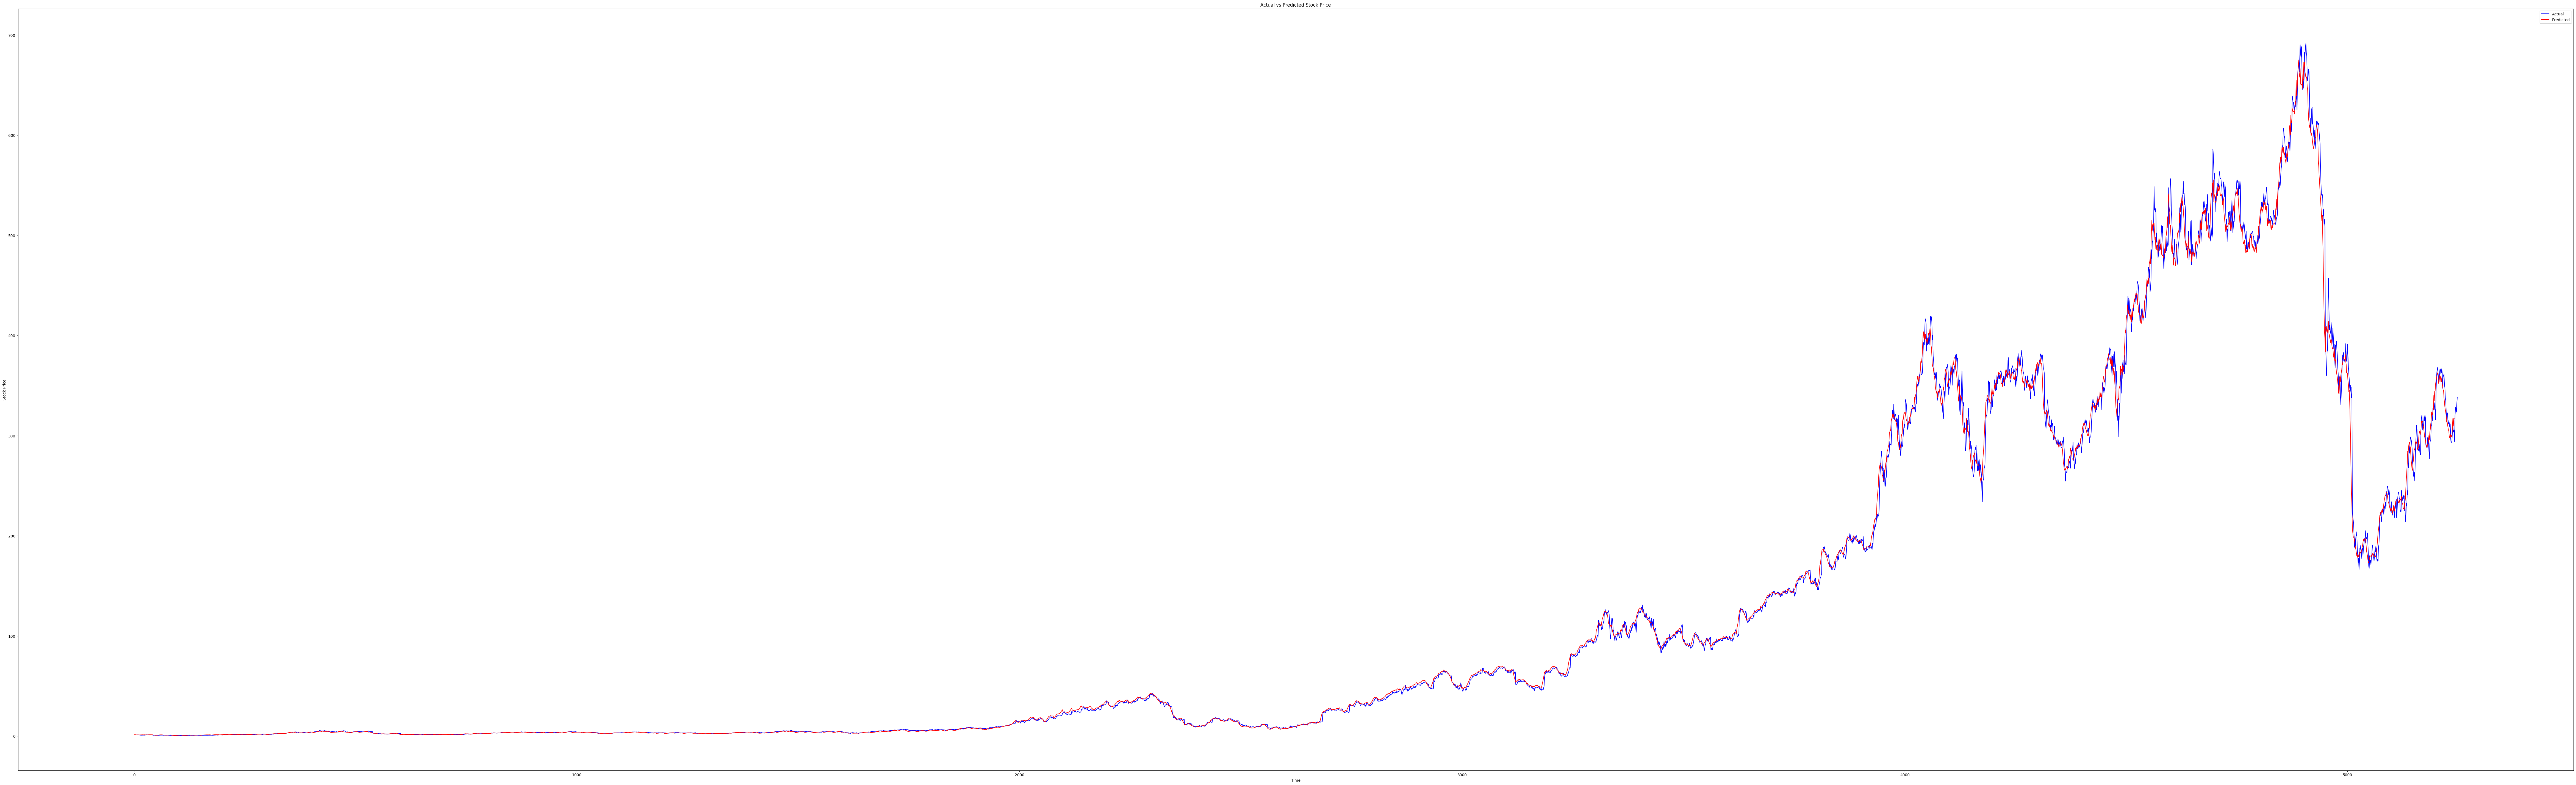

In [118]:
predicted_prices=model.predict(sliding_window(data))
actual_prices=data['Close'][7:]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(120,36))
plt.plot(actual_prices, color='blue', label='Actual')
plt.plot(predicted_prices, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()